In [1]:
from utils import load_data, check_gpu, check_dir
from clean_session import preprocess_sessions
import pandas as pd
import numpy as np
from tqdm import tqdm
import gc
import catboost as cat
import matplotlib.pyplot as plt
from clean_session import preprocess_sessions
from manual_encoding import action_encoding, click_view_encoding, meta_encoding
from hotel2vec import hotel2vec

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
%%time
train = load_data('train')
train = train[(train.action_type == 'clickout item') & (train.impressions.notna())]

CPU times: user 23.3 s, sys: 1.69 s, total: 25 s
Wall time: 25 s


In [29]:
session_size = train.groupby('session_id').size().reset_index(name='s')

In [102]:
%%time
train_last = train.groupby('session_id').last().reset_index()

CPU times: user 4.08 s, sys: 205 ms, total: 4.29 s
Wall time: 4.28 s


In [103]:
train_last = pd.merge(train_last, session_size, on='session_id')

### current_filters

In [104]:
train_last.shape

(826842, 13)

In [105]:
filters_counts = train_last.current_filters.value_counts()

In [106]:
filters_counts.head()

Sort by Price              35056
Focus on Distance          16335
Best Value                 15321
Sort By Distance            4407
Spa (Wellness Facility)     3502
Name: current_filters, dtype: int64

In [107]:
train_last.current_filters.nunique()

18921

In [108]:
train_last['cfs'] = train_last.current_filters.str.split('|')

In [109]:
all_cfs = train_last[train_last.cfs.notna()].cfs.values
all_cfs = [j for i in all_cfs for j in i]

In [110]:
all_cfs_counts = pd.value_counts(all_cfs)
all_cfs_counts.head()

Sort by Price        47122
Focus on Distance    31408
Hotel                26642
Best Value           20190
5 Star               19728
dtype: int64

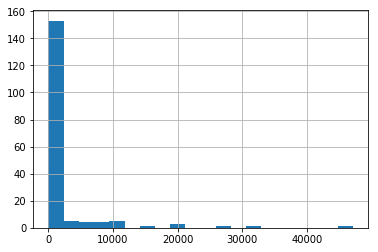

In [111]:
all_cfs_counts.hist(bins=20)

In [112]:
all_cfs_counts.shape

(178,)

In [113]:
train_last.current_filters.isna().sum()

655653

In [114]:
train_last.shape

(826842, 14)

In [115]:
655653/train_last.shape[0]

0.7929604446798784

In [116]:
train_last['nimps'] = train_last.impressions.str.split('|').str.len()

What is the length of the impressions for these with nan current_filters?

In [117]:
train_last.loc[train_last.current_filters.isna(), 'nimps'].value_counts(normalize=True).head()

25    0.759176
24    0.045899
11    0.014195
12    0.013426
13    0.012481
Name: nimps, dtype: float64

In [118]:
train_last.nimps.value_counts(normalize=True).head()

25    0.760575
24    0.041390
11    0.014730
12    0.013981
13    0.013235
Name: nimps, dtype: float64

In [119]:
train_last.loc[train_last.current_filters.notna(), 'nimps'].value_counts(normalize=True).head()

25    0.765931
24    0.024120
11    0.016777
13    0.016123
12    0.016105
Name: nimps, dtype: float64

What is the size of the session for these with nan current_filters?

In [120]:
train_last.loc[train_last.current_filters.isna(), 's'].value_counts(normalize=True).head()

1    0.652415
2    0.193581
3    0.074370
4    0.034925
5    0.017166
Name: s, dtype: float64

In [121]:
train_last.loc[train_last.current_filters.notna(), 's'].value_counts(normalize=True).head()

1    0.439573
2    0.225441
3    0.120621
4    0.070904
5    0.043215
Name: s, dtype: float64

In [122]:
train_last.s.value_counts(normalize=True).head()

1    0.608348
2    0.200177
3    0.083946
4    0.042374
5    0.022559
Name: s, dtype: float64

### Suppose we build extremly simple baseline

In [123]:
train_last['ncfs'] = train_last.cfs.str.len()

In [124]:
train_last['prices'] = train_last.prices.str.split('|')

In [125]:
%%time
train_last['prices'] = train_last.prices.apply(lambda x: np.pad(x, (0, 25-len(x)), mode='constant'))

CPU times: user 23.7 s, sys: 539 ms, total: 24.3 s
Wall time: 24.1 s


In [131]:
%%time
train_last['prices'] = train_last.prices.apply(lambda x: [int(p) for p in x])

CPU times: user 8.46 s, sys: 10.6 ms, total: 8.47 s
Wall time: 8.47 s


In [137]:
train_last['impressions'] = train_last['impressions'].str.split('|')
train_last['impressions'] = train_last['impressions'].apply(lambda x: [int(i) for i in x])

In [142]:
%%time
# make target
def make_target(x):
    try:
        return x.impressions.index(int(x.reference))
    except Exception as e:
#         print(e)
        return 25
train_last['target'] = train_last.apply(make_target, axis=1)

CPU times: user 24 s, sys: 55.7 ms, total: 24.1 s
Wall time: 24.1 s


In [144]:
train_last.head(2)

,session_id,user_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices,s,cfs,nimps,ncfs,target
0,00000510f1adc,WT30CXPIG450,1541064087,1,clickout item,7281198,IN,"Ganpatipule, India",desktop,NaN,"[2661832, 9222426, 7051844, 4079190, 5752778, ...","[46, 26, 16, 38, 12, 20, 21, 27, 13, 21, 36, 9...",1,NaN,25,NaN,6
1,00003f3b20954,CITFOTN2IT5P,1541097696,1,clickout item,979325,ES,"La Manga, Spain",mobile,NaN,"[87132, 886881, 486611, 979325, 87173, 87175, ...","[330, 187, 437, 159, 499, 324, 476, 381, 424, ...",1,NaN,25,NaN,3


In [145]:
train_last = train_last.drop(['user_id', 'action_type', 'current_filters', 'impressions', 'cfs'], axis=1)

In [146]:
train_last.head()

,session_id,timestamp,step,reference,platform,city,device,prices,s,nimps,ncfs,target
0,00000510f1adc,1541064087,1,7281198,IN,"Ganpatipule, India",desktop,"[46, 26, 16, 38, 12, 20, 21, 27, 13, 21, 36, 9...",1,25,NaN,6
1,00003f3b20954,1541097696,1,979325,ES,"La Manga, Spain",mobile,"[330, 187, 437, 159, 499, 324, 476, 381, 424, ...",1,25,NaN,3
2,000056cd97ce2,1541484101,4,3811810,MY,"Port Dickson, Malaysia",desktop,"[187, 78, 100, 51, 150, 81, 44, 36, 53, 104, 9...",2,25,NaN,0
3,000066611146f,1541332330,3,5479306,BE,"Obaköy, Turkey",desktop,"[96, 81, 87, 122, 50, 21, 90, 177, 81, 144, 12...",1,25,2.0,0
4,0000be39860d7,1541104090,53,79237,US,"Chattanooga, USA",desktop,"[171, 218, 132, 209, 202, 60, 123, 145, 154, 1...",2,25,NaN,19


In [147]:
price_df = pd.DataFrame(train_last.prices.to_list(), columns=[f'price_{i}' for i in range(25)])

In [148]:
del train_last['prices']
train_last = pd.concat([train_last, price_df], axis=1)

In [149]:
train_last.head()

,session_id,timestamp,step,reference,platform,city,device,s,nimps,ncfs,...,price_15,price_16,price_17,price_18,price_19,price_20,price_21,price_22,price_23,price_24
0,00000510f1adc,1541064087,1,7281198,IN,"Ganpatipule, India",desktop,1,25,NaN,...,19,22,20,9,16,21,15,65,20,20
1,00003f3b20954,1541097696,1,979325,ES,"La Manga, Spain",mobile,1,25,NaN,...,482,182,158,505,720,110,330,570,492,450
2,000056cd97ce2,1541484101,4,3811810,MY,"Port Dickson, Malaysia",desktop,2,25,NaN,...,26,33,20,15,38,20,62,28,24,18
3,000066611146f,1541332330,3,5479306,BE,"Obaköy, Turkey",desktop,1,25,2.0,...,75,76,88,66,38,100,128,32,48,59
4,0000be39860d7,1541104090,53,79237,US,"Chattanooga, USA",desktop,2,25,NaN,...,180,151,123,140,141,177,140,180,84,122


In [150]:
from sklearn.model_selection import StratifiedKFold, KFold
folds = StratifiedKFold(n_splits=5)

In [152]:
targets = train_last.target.values
train_last = train_last.drop(['session_id', 'reference', 'target'], axis=1)

In [153]:
from utils import check_gpu
device = 'GPU' if check_gpu() else 'CPU'
params = {'iterations': 200,
          'learning_rate': 0.03,
          'depth': 6,
          'task_type': device,
          'loss_function': 'MultiClass',
          'custom_metric': ['MultiClass', 'Accuracy', 'AUC', 'Precision', 'Recall'],
          'eval_metric': 'MultiClass'}

In [154]:
train_last.head()

,timestamp,step,platform,city,device,s,nimps,ncfs,price_0,price_1,...,price_15,price_16,price_17,price_18,price_19,price_20,price_21,price_22,price_23,price_24
0,1541064087,1,IN,"Ganpatipule, India",desktop,1,25,NaN,46,26,...,19,22,20,9,16,21,15,65,20,20
1,1541097696,1,ES,"La Manga, Spain",mobile,1,25,NaN,330,187,...,482,182,158,505,720,110,330,570,492,450
2,1541484101,4,MY,"Port Dickson, Malaysia",desktop,2,25,NaN,187,78,...,26,33,20,15,38,20,62,28,24,18
3,1541332330,3,BE,"Obaköy, Turkey",desktop,1,25,2.0,96,81,...,75,76,88,66,38,100,128,32,48,59
4,1541104090,53,US,"Chattanooga, USA",desktop,2,25,NaN,171,218,...,180,151,123,140,141,177,140,180,84,122


In [155]:
categorical_cols = ['platform', 'city', 'device']
categorical_ind = [k for k, v in enumerate(train_last.columns) if v in categorical_cols]

In [156]:
categorical_ind

[2, 3, 4]

In [ ]:
for fold, (trn_ind, val_ind) in enumerate(folds.split(targets, targets)):
    x_trn, y_trn = train_last.iloc[trn_ind], targets[trn_ind]
    x_val, y_val = train_last.iloc[val_ind], targets[val_ind]

    # train model
    clf = cat.CatBoostClassifier(**params)
    clf.fit(x_trn.values, y_trn,
            cat_features=categorical_ind,
            eval_set=(x_val.values, y_val),
            early_stopping_rounds=100,
            verbose=10,
            plot=False)
    
    trn_pred = clf.predict(x_trn.values)
    val_pred = clf.predict(x_val.values)
    
    trn_mrr = np.mean(1/(np.where(np.argsort(trn_pred)[:, ::-1] == y_trn.reshape(-1, 1))[1]+1))
    val_mrr = np.mean(1/(np.where(np.argsort(val_pred)[:, ::-1] == y_val.reshape(-1, 1))[1]+1))
    print(trn_mrr, val_mrr)


0:	learn: -3.1837517	test: -3.1838718	best: -3.1838718 (0)	total: 7.31s	remaining: 12m 3s
10:	learn: -2.8223716	test: -2.8229093	best: -2.8229093 (10)	total: 3m 24s	remaining: 27m 37s


## now look at test

In [ ]:
%%time
test = load_data('test')

In [ ]:
%%time
sub = load_data('submission_popular')

In [ ]:
test_sub = test[test.session_id.isin(sub.session_id)].reset_index(drop=True)

In [ ]:
test_sub['nimp'] = test_sub.impressions.str.split('|').str.len()

In [ ]:
# sub[sub.session_id.isin(test_sub[test_sub.nimp==1].session_id)]

In [ ]:
test_sub_last = test_sub.groupby('session_id').last().reset_index() # this may not be ideal

In [ ]:
test_sub_last.shape

In [ ]:
test_sub_city_counts = test_sub_last.city.value_counts()
test_sub_city_counts.head()

In [ ]:
test_sub_city_counts_cs = test_sub_city_counts.cumsum()/(test_sub_city_counts.sum())
test_sub_city_counts_cs.head()

In [ ]:
print(th)
test_sub_above_th = test_sub_city_counts_cs[test_sub_city_counts_cs<th]
print(test_sub_above_th.shape)
common_test_sub_cities = test_sub_above_th.index.values

number of common cities intersections with trains

In [ ]:
len(set(common_test_sub_cities).intersection(common_cities))

number of impression list with len 1

In [ ]:
test_sub_last['imp_list'] = test_sub_last.impressions.str.split('|')

In [ ]:
test_sub_imp_len = test_sub_last.imp_list.str.len()

In [ ]:
test_sub_imp_len.value_counts()

In [ ]:
866/test_sub_last.shape[0]*100

In [ ]:
# test_sub_last[~test_sub_last.city.isin(common_test_sub_cities)].imp_list.str.len().value_counts()

### platform

In [ ]:
platfrom_counts = train_last.platform.value_counts()
platfrom_counts.head()

In [ ]:
platfrom_counts.hist(bins=50)

In [ ]:
np.log1p(platfrom_counts).hist(bins=50)

In [ ]:
platfrom_counts.shape

In [ ]:
train.platform.nunique()

In [ ]:
(55)**(1/4)

In [ ]:
train.city.nunique()

In [ ]:
30519**(1/4)